#### Import Modules

In [3]:
import pandas as pd
import sys, os

sys.path.append(os.path.abspath(os.path.join('../scripts')))
from eda_pipeline import EDAPipeline
from plot_util import *

#### Initialize EDAPipeline

In [4]:
eda_pipeline = EDAPipeline()

In [5]:
df_trip = eda_pipeline.read_data(path="../data/nb.csv", version="v1_nb")
df_trip.info()
# df_trip

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536020 entries, 0 to 536019
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Trip ID           536020 non-null  int64 
 1   Trip Origin       536020 non-null  object
 2   Trip Destination  536020 non-null  object
 3   Trip Start Time   534369 non-null  object
 4   Trip End Time     536019 non-null  object
dtypes: int64(1), object(4)
memory usage: 20.4+ MB


In [6]:
df_driver = eda_pipeline.read_data(path="../data/driver_locations_during_request.csv", version="v1_driver")
df_driver.info()
# df_driver

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557740 entries, 0 to 1557739
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   id             1557740 non-null  int64  
 1   order_id       1557740 non-null  int64  
 2   driver_id      1557740 non-null  int64  
 3   driver_action  1557740 non-null  object 
 4   lat            1557740 non-null  float64
 5   lng            1557740 non-null  float64
 6   created_at     0 non-null        float64
 7   updated_at     0 non-null        float64
dtypes: float64(4), int64(3), object(1)
memory usage: 95.1+ MB


##### Drop rows with null value for column: `Trip Start Time`

In [7]:
df_trip['Trip Start Time'].isna().sum()

1651

In [8]:
df_trip = df_trip[df_trip['Trip Start Time'].notna()]
df_trip.shape

(534369, 5)

##### Check if  `Trip Start Time` is weekend or not 

In [9]:
df_trip['is_weekend'] = df_trip['Trip Start Time'].apply(lambda x: eda_pipeline.isWeekend(x))

In [10]:
df_trip['is_weekend'].value_counts()
# 0 means the date is not weekend

0    427182
1    107187
Name: is_weekend, dtype: int64

##### Weekends distribution

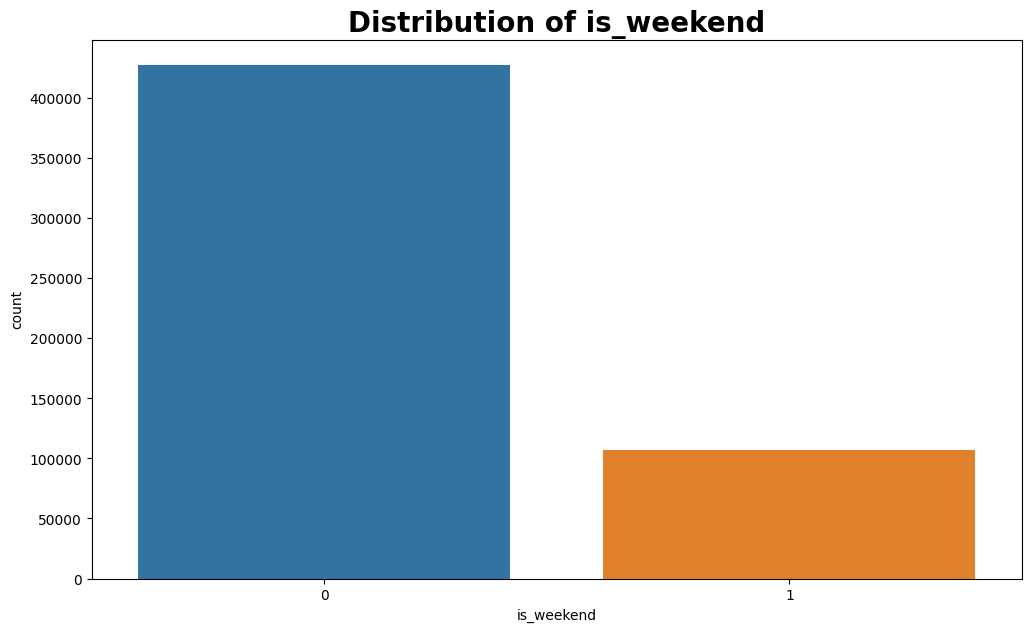

In [11]:
plot_count(df_trip, 'is_weekend')

##### Check for holidays

In [12]:
df_trip['is_holiday'] = df_trip['Trip Start Time'].apply(lambda x: eda_pipeline.isHoliday(x))

In [13]:
df_trip['is_holiday'].value_counts()

0    525289
1      9080
Name: is_holiday, dtype: int64

##### Holiday distribution

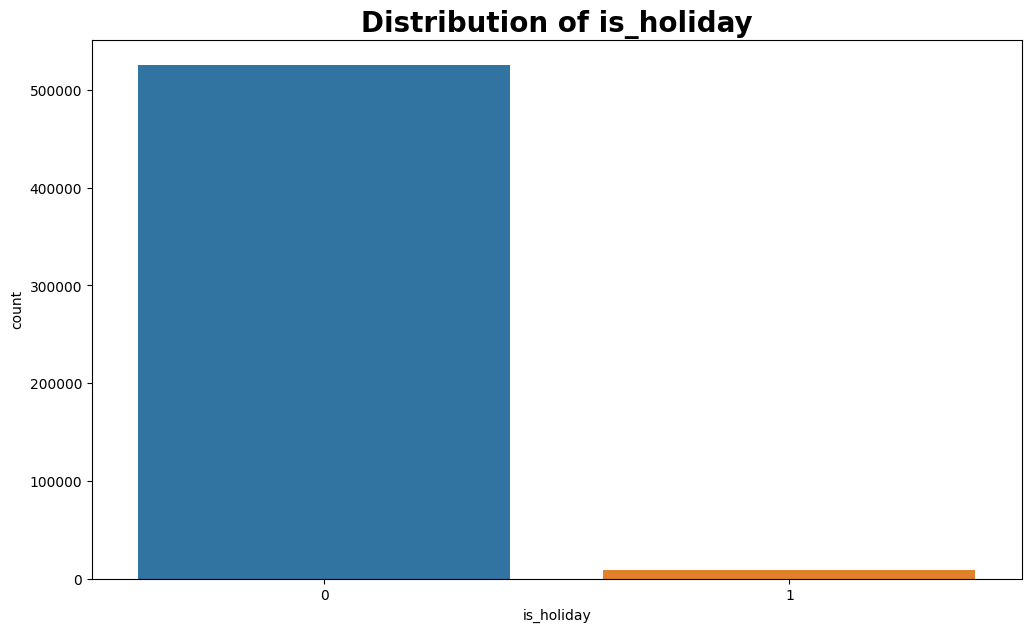

In [14]:
plot_count(df_trip, 'is_holiday')

##### Check for weather status

In [15]:
from weather_api_connector import WeatherAPIConnector 

In [16]:
weather_checker = WeatherAPIConnector()
# some_df = df_trip.assign(is_raining=lambda x: weather_checker.get_daily_weather(x['Trip Start Time'], str(x['Trip Origin']).split(',')[0], str(x['Trip Origin']).split(',')[1]))

##### Calculate Distance

In [17]:
start_coordinates = df_trip['Trip Origin'].tolist()
end_coordinates = df_trip['Trip Destination'].tolist()

In [18]:
df_trip['distance'] = eda_pipeline.calculate_distances(start_coordinates, end_coordinates)

In [19]:
df_trip['distance'].describe()

count    534369.000000
mean         12.099933
std          11.025363
min           0.000000
25%           5.560139
50%          10.510693
75%          16.993854
max         680.080847
Name: distance, dtype: float64

In [20]:
# plotly_plot_scatter(df_trip, 'distance','Trip ID', 8)
#plot is found in screenshots/plots/ folder

In [21]:
df_trip['distance'].value_counts()

2.467037     132
0.000000     121
8.040819     102
17.456076     95
22.388326     73
            ... 
16.118600      1
1.470260       1
13.508368      1
8.679657       1
22.657280      1
Name: distance, Length: 466406, dtype: int64

##### Get Speed (km/hr)

In [22]:
start_date_times = df_trip['Trip Start Time'].tolist()
end_date_times = df_trip['Trip End Time'].tolist()
distance_list = df_trip['distance'].tolist()

In [23]:
df_trip['speed'] = eda_pipeline.calculate_speeds(start_date_times, end_date_times, distance_list)

In [21]:
df_trip['speed'].describe()

count    534369.000000
mean         26.570059
std         244.737329
min           0.000000
25%           6.876641
50%          11.137486
75%          16.815429
max       66498.868759
Name: speed, dtype: float64

In [ ]:
# plotly_plot_scatter(df_trip, 'speed', 'Trip ID', 8)
#plot is found in screenshots/plots/ folder

##### Handle speed and distance outliers

I will try to understand the outliers in distance column using speed, which means if the speed is too high which is the result of trying to go long distances with in few minutes, for example for a motor bike you can not go `672` km in `30` minutes, this means either the location is wrong or the distance is an outlier

In [28]:
df_distance_outliers = df_trip[df_trip['distance']>50]

In [29]:
df_distance_outliers[['Trip ID', 'Trip Start Time', 'Trip End Time', 'distance', 'speed']]

,Trip ID,Trip Start Time,Trip End Time,distance,speed
891,393572,2021-07-01 11:48:09,2021-07-01 11:52:32,52.840859,723.296929
1122,394008,2021-07-01 12:18:42,2021-07-01 14:41:39,56.343718,23.648990
2422,396558,2021-07-01 15:58:05,2021-07-01 18:08:09,56.292206,25.967701
3428,398525,2021-07-02 07:48:44,2021-07-02 08:14:49,672.026066,1545.874656
4474,400634,2021-07-02 11:44:18,2021-07-02 11:48:56,667.559260,8644.652285
...,...,...,...,...,...
519764,1578624,2021-12-22 17:04:16,2021-12-22 22:17:41,52.399714,10.031320
521502,1586390,2021-12-23 12:32:35,2021-12-23 15:27:38,50.999013,17.480382
523354,1596600,2021-12-24 09:35:47,2021-12-24 15:13:53,71.334946,12.659263
524740,1606367,2021-12-25 09:11:38,2021-12-25 12:10:19,52.364448,17.583436


In [30]:
df = df_driver[df_driver['driver_action']=='accepted']

In [34]:
top10 = df['driver_id'].value_counts().head(10)

In [38]:
top10

243296    69
245611    63
227856    60
244107    60
245649    59
243648    58
171149    58
243500    58
245587    57
243892    57
Name: driver_id, dtype: int64

<AxesSubplot: >

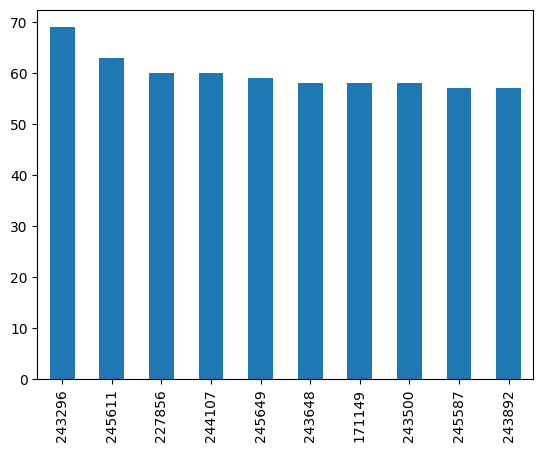

In [37]:
top10.plot(kind='bar')

In [34]:
df_trip_na_trip_start = df_trip[df_trip['Trip Start Time'].isna()]
vals = df_trip_na_trip_start['Trip ID'].unique().tolist()

In [31]:
def has_driver_data(order):
    if order['order_id'] in vals:
        if order['driver_action'] == "accepted":
            return 1
        else:
            return 2
    return 0

df_driver_for_na_trip_startc = df_trip_na_trip_start.copy()
df_driver_for_na_trip_startc['has_driver'] = df_driver.apply(lambda x: has_driver_data(x))
df_driver_for_na_trip_startc.shape

# l = 0
# for i,trip in enumerate(df_trip_na_trip_start):
#     print(trip)
#     df_driver_for_na_trip_start = df_driver[df_driver['order_id']==trip[i]['Trip ID']]
#     if len(df_driver_for_na_trip_start) > 0:
#         l+=1
# print(l)

(1557740, 9)

In [6]:
# eda_pipeline.isWeekend("2021-07-01 07:28:04")
# df_trip['is_weekend'] = df_trip['Trip Start Time'].apply(lambda x: eda_pipeline.isWeekend(x))
# df_trip['is_weekend'].tail()

In [24]:
df_trip.to_csv("../data/preprocessed_trip.csv")